### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2019)

* The lab exercises can be done in groups of two people, or individually.
* The deadline is Tuesday, October 15th at 17:00.
* Assignment should be submitted through Canvas! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [2]:
def binarize(X):
    # to get the pixel values in the range [0,1]
    X = X/255
    
    # threshold at 0.5
    binary_X = (X > 0.5).astype(float)
                     
    return binary_X

In [3]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

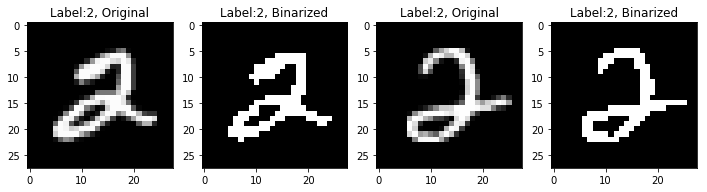

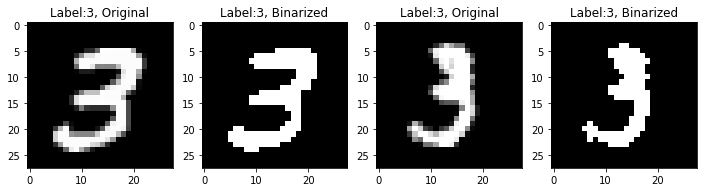

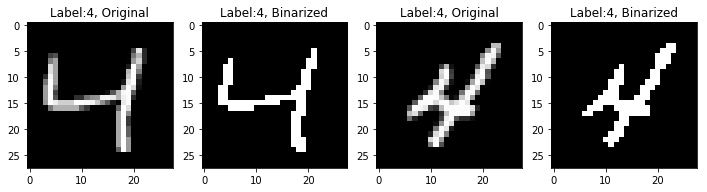

In [4]:
for digit in [2,3,4]:
    
    fig = plt.figure(figsize=(12,7))
    index = np.where(train_labels == digit)[0][:2]

    plt.subplot(141)
    plt.imshow(train_data[index[0]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[0]]) + ", Original")
    plt.subplot(142)
    plt.imshow(bin_train_data[index[0]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[0]])+ ", Binarized")
    plt.subplot(143)
    plt.imshow(train_data[index[1]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[1]]) + ", Original")
    plt.subplot(144)
    plt.imshow(bin_train_data[index[1]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[1]])+ ", Binarized")
    plt.show()


### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [5]:
from scipy.special import logsumexp

# def E_step(X, mu, pi):
#     # expand dim to vectorize
#     x_e = np.expand_dims(X, axis=1)
#     gamma_unnorm = np.multiply.reduce((mu**x_e) * ((1-mu)**(1-x_e)), axis =2)
#     gamma_unnorm = pi * gamma_unnorm 
#     norm = np.sum(gamma_unnorm, axis=1)
#     gamma = np.divide(gamma_unnorm.T, norm).T    
#     return gamma

def E_step(X, mu, pi):
    # Add small number to avoid zero's
    e = 1e-10
    gamma = X @ np.log(mu + e).T + (1. - X) @ np.log(1. - mu + e).T + np.log(pi)
    # Log sum trick: http://bayesjumping.net/log-sum-exp-trick/
    return np.exp(gamma - logsumexp(gamma, axis=1, keepdims=True))

In [6]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [7]:
def M_step(X, gamma):
    # calculate N_k by summing gamma across "N" dimension
    N_k = np.sum(gamma, axis = 0)
    # Update for pi
    pi = N_k/np.sum(gamma, axis=(0,1))
    
#     mu = np.zeros((gamma.shape[0], gamma.shape[1]))
    gamma = gamma.T
    X = X.T
    
    gamma = np.expand_dims(gamma, axis=1)
    mu_unnorm = np.sum(gamma * X, axis =2)
    mu = mu_unnorm.T/N_k
    return mu.T, pi
    
    

In [8]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [9]:
from tqdm import tqdm_notebook as tqdm

def EM(X, K, max_iter, mu=None, pi=None, output=0):
    N = X.shape[0]
    D = X.shape[1]
    eps = 1e-5
    
    if mu is None:
        # random initialization
        mu = np.random.uniform(low=.25, high=.75, size = (K, D))
        
    if pi is None:
        # Uniform initialization
        pi = np.ones(K) / K
    
    gamma = np.zeros((N, K))
    for i in tqdm(range(max_iter)):
        
        # Expectation step
        gamma_new = E_step(X, mu, pi)
        
        # Maximization step
        mu, pi = M_step(X, gamma_new)
    
        delta_gamma = np.linalg.norm(gamma_new - gamma) / N
        
        if output and not (i%output):
            print(f"Step {i}: delta: {delta_gamma}")          
        
        if delta_gamma < eps:
            break
        gamma = gamma_new
    
    return mu, pi, gamma

### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

Step 0: delta: 0.01812095840203899
Step 10: delta: 0.0008999030077884321
Step 20: delta: 0.0003686129489945081
Step 30: delta: 1.895180503656333e-05



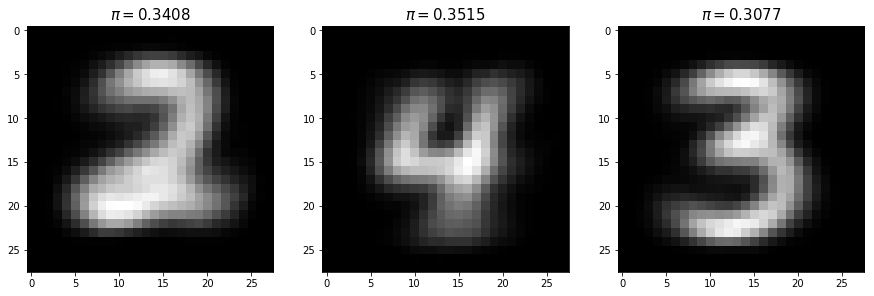

In [10]:
# TOOD: check why gamma becomes nan during training. 

def get_training_data(all_data, all_labels, labels, nr_samples=3):
    
    len_t_data = len(labels) * nr_samples
    out_data = np.empty((len_t_data, 784))
    out_labels = np.empty((len_t_data, 1))
    
    for i, d in enumerate(labels):
        
        # Get indices of interest
        digit_i = np.argwhere(all_labels == d)
        digit_i = digit_i.reshape(digit_i.shape[0])
        
        # Chose a random sample from those digits
        dig_i_sample = np.random.choice(digit_i, nr_samples, replace=False)
        
        # Get the corresponding data and binarize it.
        dig_data = binarize(all_data[dig_i_sample])
        
        # add labels and data to the output
        start_i = i * nr_samples
        end_i = (i + 1) * nr_samples
        out_labels[start_i:end_i] = d * np.ones((nr_samples,1))
        out_data[start_i:end_i] = dig_data
        
    return out_data, out_labels

def plot_mu_pi(K, mu, pi, title_string=None):
    K  = mu.shape[0]
    figure(figsize=(5*K,11))
    if title_string is not None:
        suptitle(title_string, size=50)
    for i in range(K):
        subplot(1,K,i+1)
        imshow(mu[i].reshape(28,28), cmap='gray')
        title(f'$\pi={str(round(pi[i], 4))}$', size=15)
    
classes = [2,3,4]
max_iter = 100
train_subset, subset_labels = get_training_data(train_data, train_labels, classes, nr_samples=1000)
rez_mu, rez_pi, _ = EM(train_subset, len(classes), max_iter, output=10)
plot_mu_pi(3, rez_mu, rez_pi)

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

*** Make a better answer ***

We can clearly see how the correspondence between the $\mu$'s and their classes. The mixing coeficients are close to $1/3$, which is expected beause all classes are equally represented during training (they all have the same number of sampels).

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

Step 0: delta: 0.01748135940389278
Step 10: delta: 0.001732108004093485
Step 20: delta: 0.0009565281291148088
Step 30: delta: 0.0009179550890753301
Step 40: delta: 0.0013228367866445728



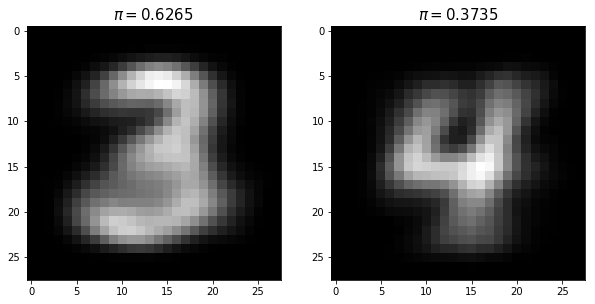

In [11]:
classes = [2,3,4]
max_iter = 100
train_subset, subset_labels = get_training_data(train_data, train_labels, classes, nr_samples=1000)
rez_mu, rez_pi, _ = EM(train_subset, 2, max_iter, output=10)
plot_mu_pi(2, rez_mu, rez_pi)

Step 0: delta: 0.01673746004592797
Step 10: delta: 0.0025549198068058098
Step 20: delta: 0.0009934886609736676
Step 30: delta: 0.0003327281995305222
Step 40: delta: 0.00039794067728595903
Step 50: delta: 0.00035025325185200206
Step 60: delta: 0.0005623813203937191
Step 70: delta: 9.271781596718703e-05
Step 80: delta: 0.0001320137132781503
Step 90: delta: 2.1584949043012734e-05


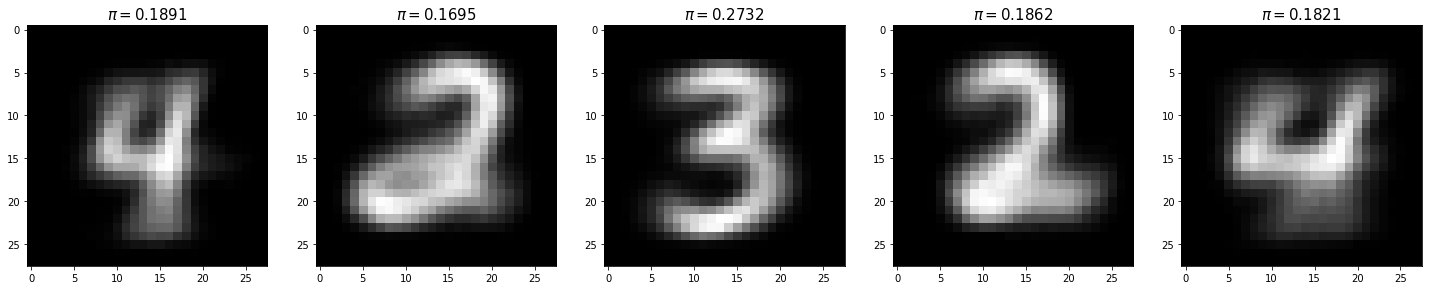

In [12]:
classes = [2,3,4]
max_iter = 100
train_subset, subset_labels = get_training_data(train_data, train_labels, classes, nr_samples=1000)
rez_mu, rez_pi, _ = EM(train_subset, 5, max_iter, output=10)
plot_mu_pi(5, rez_mu, rez_pi)

YOUR ANSWER HERE

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

In [13]:
# YOUR CODE HERE
# raise NotImplementedError()

YOUR ANSWER HERE

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

In [14]:
# YOUR CODE HERE
# raise NotImplementedError()

YOUR ANSWER HERE

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [15]:
def log_bernoulli_loss(x_hat, x): 
    return - torch.sum( x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat))


In [16]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!


\begin{align} 
    KL(q || p) &= - \int q(\mathbf{z}) \ln \big( \frac{p(\mathbf{z})}{q(\mathbf{z})} \big)  d\mathbf{z} \\
    &= -\int q(\mathbf{z}) \big( \ln p(\mathbf{z}) - q(\mathbf{z}) \big) d\mathbf{z} \\
    &= -\int q(\mathbf{z}) \ln p(\mathbf{z}) d\mathbf{z} - \big[ - \int q(\mathbf{z}) \ln q(\mathbf{z}) d\mathbf{z} \big]
\end{align}

We can divide the problem in two similar integrals. This kind of integral with normals as functions $p$ and $q$ is known. As derived in homework 2, if $p(\mathbf{z}) = \mathcal{N}(\mathbf{z} | \mathbf{m}, \mathbf{L})$ and $q=\mathcal{N}(\mathbf{z} | \boldsymbol{\mu}, \boldsymbol{\Sigma})$, then 

\begin{align} 
    -\int q(\mathbf{z}) \ln p(\mathbf{z}) d\mathbf{z} &= \frac{D}{2} \ln 2 \pi +\frac{1}{2} \ln |\mathbf{L}| +\frac{1}{2} Tr(\mathbf{L}^{-1} \boldsymbol{\Sigma}) +\frac{1}{2} (\boldsymbol{\mu} - \mathbf{m})^T L^{-1} (\boldsymbol{\mu} - \mathbf{m})   
\end{align}

For the variational autoencoder case, we have then 
\begin{align} 
    -\int q(\mathbf{z}) \ln p(\mathbf{z}) d\mathbf{z} &= \frac{D}{2} \ln 2 \pi +\frac{1}{2} \ln |\mathbf{L}| +\frac{1}{2} Tr(\mathbf{L}^{-1} \boldsymbol{\Sigma}) +\frac{1}{2} (\boldsymbol{\mu} - \mathbf{m})^T \mathbf{L}^{-1} (\boldsymbol{\mu} - \mathbf{m}) \\
    &= \frac{D}{2} \ln 2 \pi +\frac{1}{2} Tr( \boldsymbol{\sigma}^2 \mathbf{I}) +\frac{1}{2} \boldsymbol{\mu} ^T \boldsymbol{\mu} \\
    &= \frac{D}{2} \ln 2 \pi +\frac{1}{2} \sum_{d=1}^{D} (\sigma_d^2 + \mu^2)\ -\int q(\mathbf{z}) \ln q(\mathbf{z}) d\mathbf{z}  \\
    &= \frac{D}{2} \ln 2 \pi +\frac{1}{2} \ln |\boldsymbol{\Sigma}| +\frac{D}{2} \\
    &= \frac{D}{2} \ln 2 \pi +\frac{1}{2} \sum_{d=1}^{D} \log \sigma_d^2 +\frac{D}{2} 
\end{align}

Putting it all together:

\begin{align}
KL(q||p) = -\frac{1}{2} \sum_{d=1}^D \left(1 + \ln \sigma_d^2 - \sigma_d^2 - \mu_d^2 \right)
\end{align}

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [17]:
def KL_loss(mu, logvar):

    return - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp().pow(2))


In [18]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [19]:
def loss_function(x_hat, x, mu, logvar):
    
    b_loss = log_bernoulli_loss(x_hat, x)
    kl_loss = KL_loss(mu, logvar)
    return b_loss + kl_loss


In [20]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [21]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [22]:
def encode(self, x):
    
    emb = F.relu(self.fc1(x))
    
    mu = self.fc21(emb)
    
    logvar = self.fc22(emb)
    
    return mu, logvar

In [23]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [24]:
def reparameterize(self, mu, logvar): 
        
        epsilon = torch.randn(mu.shape)
        std = logvar.exp().sqrt()
        z = mu + std * epsilon
        
        return z


In [25]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [26]:
def decode(self, z):
    
    out = self.fc4(F.relu(self.fc3(z)))
    
    # output must be between zero and one, so we give our network some slack:
    x_hat = F.sigmoid(out)
    
    return x_hat


In [27]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


C:\Users\asus\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [28]:
def forward(self, x):
    x = x.view(-1, 784)
    
    # get mu and logvar:
    mu, logvar = self.encode(x)
    
    # step into the messy latent space:
    z = self.reparameterize(mu, logvar)
    
    # get image back:
    x_hat = self.decode(z)
    
    return x_hat, mu, logvar


In [29]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [30]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [31]:
# Hyperparameters
size_X = 784 
size_H = size_X //2 
size_Z = 2  
fc1_dims = (size_X, size_H)
fc21_dims = (size_H, size_Z)
fc22_dims = (size_H, size_Z)
fc3_dims = (size_Z, size_H)
fc4_dims = (size_H, size_X)
lr = 1e-3
batch_size = 1024
epochs = 10

In [32]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [33]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 553.139648
====> Epoch: 1 Average loss: 250.9500
Train Epoch: 2 [0/60000 (0%)]	Loss: 199.533371
====> Epoch: 2 Average loss: 191.0934
Train Epoch: 3 [0/60000 (0%)]	Loss: 186.079910
====> Epoch: 3 Average loss: 183.4718
Train Epoch: 4 [0/60000 (0%)]	Loss: 177.697830
====> Epoch: 4 Average loss: 178.3595
Train Epoch: 5 [0/60000 (0%)]	Loss: 174.458344
====> Epoch: 5 Average loss: 174.3982
Train Epoch: 6 [0/60000 (0%)]	Loss: 172.385071
====> Epoch: 6 Average loss: 171.4828
Train Epoch: 7 [0/60000 (0%)]	Loss: 168.342667
====> Epoch: 7 Average loss: 169.3876
Train Epoch: 8 [0/60000 (0%)]	Loss: 170.092880
====> Epoch: 8 Average loss: 167.6995
Train Epoch: 9 [0/60000 (0%)]	Loss: 167.668518
====> Epoch: 9 Average loss: 166.3322
Train Epoch: 10 [0/60000 (0%)]	Loss: 165.684326
====> Epoch: 10 Average loss: 165.2258


Run the box below to check if the model you trained above is able to correctly reconstruct images.

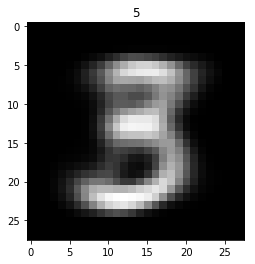

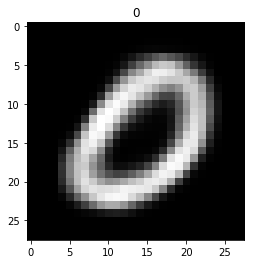

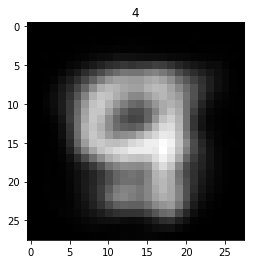

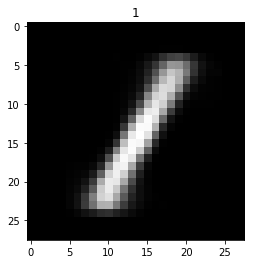

In [34]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

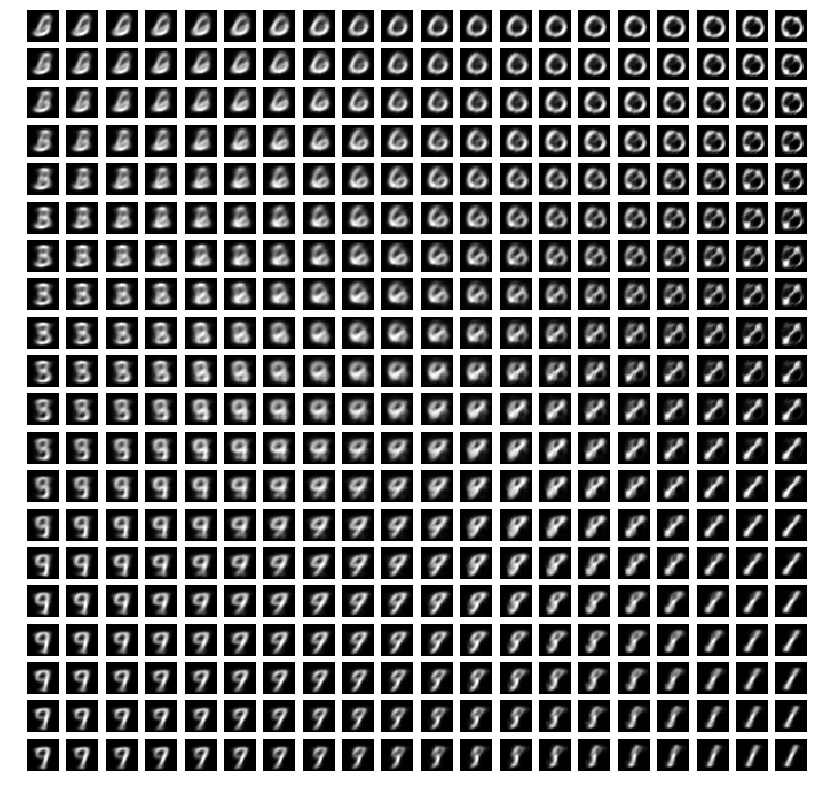

In [36]:
N = 20
grid = np.linspace(-np.sqrt(3), np.sqrt(3), N)
figures, axes = plt.subplots(N, N, figsize=(14,14))

for ix, xx in enumerate(grid):
    for iy, yy in enumerate(grid):
        
        z = torch.FloatTensor([xx, yy]).unsqueeze(0)
        x = VAE_MNIST.decode(z).data.numpy()
        axes[ix, iy].imshow(x.reshape(28, -1), cmap='gray')
        axes[ix, iy].axis('off')

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


In variational inference, the posterior optimizes a separate variational parameter for each data point, which can be prohibitive in some settings. Amortized variational inference updates a function that maps from the data to the distribution of latent variables. In theory, it is possible to recover any datapoint from given its latent encoding, up to an arbitrary error. 

In the VAE the Encoder performns the amortized inference by mapping datapoints to a latent space